In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

print(torch.__version__,torch.cuda.is_available())

2.6.0+cu124 True


In [3]:
transform = transforms.Compose([
    transforms.Resize((28,28)),  # Resize all images to 28x28
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


train_data = datasets.FashionMNIST(root="fashion",
                              train=True,
                              download=True,
                              transform=transform,
                              target_transform=None)


test_data = datasets.FashionMNIST(root="fashion",
                              train=False,
                              download=True,
                              transform=transform,
                              target_transform=None)
train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: fashion
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: fashion
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 28, 28])


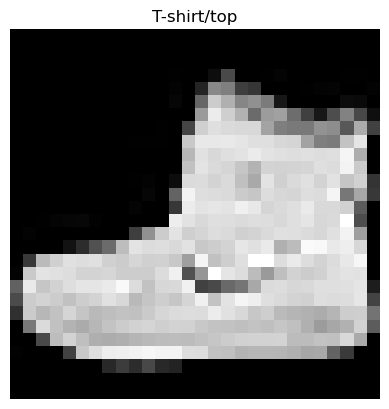

In [5]:
image,label = train_data[0]

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.imshow(image.squeeze()[0], cmap='gray')
# plt.title('Red Channel')
# plt.subplot(1,3,2)
# plt.imshow(image.squeeze()[1], cmap='gray')
# plt.title('Green Channel')
# plt.subplot(1,3,3)
# plt.imshow(image.squeeze()[2], cmap='gray')
# plt.title('Blue Channel')
plt.axis(False)
plt.title(class_names[0])
plt.imshow(image[0],cmap="gray")
print(image.shape)

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)


test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


len(train_dataloader),len(test_dataloader)

(1875, 313)

In [7]:
train_features_batch,train_labels_batch = next(iter(test_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

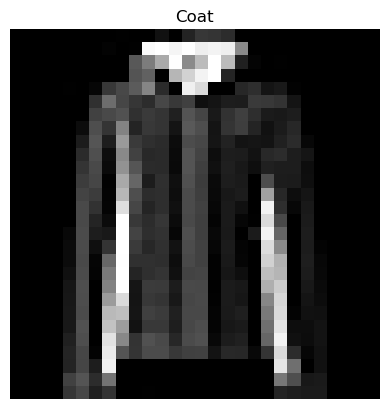

In [8]:
torch.manual_seed(42)
train_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[train_idx], train_labels_batch[train_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [9]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Before Flattening {x.shape} ")
print(f"After Flattening {output.shape}")

Before Flattening torch.Size([1, 28, 28]) 
After Flattening torch.Size([1, 784])


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class FashionModelBase(nn.Module):
    
    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    
    def forward(self,x):
        return self.layers(x)
    

In [12]:
model_0 = FashionModelBase(input_shape=28*28,hidden_units=10,output_shape=len(class_names)).to(device)
model_0

FashionModelBase(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
import requests
from pathlib import Path
github_file_link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py"
if Path("helper_functions.py").is_file():
    print("File Already Exists, Skipping Download....")
else:
    response = requests.get(github_file_link)

    if response.status_code==200:
        with open("helper_functions.py","wb") as f:
            f.write(response.content)
    else:
        print("File Download Error")

File Already Exists, Skipping Download....


In [14]:
from helper_functions import accuracy_fn

accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

In [15]:
from timeit import default_timer as timer


def execution_time(start_time,end_time, device):
    total_time = end_time-start_time
    print(f"Train Time on {device} is {total_time:.4f}")
    return total_time

start_time = timer()

end_time = timer()

execution_time(start_time,end_time,"cpu")

Train Time on cpu is 0.0000


9.798997780308127e-06

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)


In [17]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_on_cpu_start = timer()


epochs =1

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n")
    
    train_loss=0
    for batch,(X,y) in enumerate(train_dataloader):
        model_0.train()
        X,y = X.to(device),y.to(device)
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred,y)
        
        train_loss +=loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
        
        n = len(train_dataloader.dataset)
        if batch%20 == 0:
            print(f'Train Epoch: {epoch} [{batch * len(X)}/{n} '
                  f'({100. * batch / len(train_dataloader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    train_loss /= len(train_dataloader)
    
    
    test_loss,test_acc = 0,0
    
    model_0.eval()
    
    with torch.inference_mode():
        
        
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device),y_test.to(device)
            test_pred = model_0(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)
            
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))
            
            test_loss/=len(test_dataloader)
            
            test_acc/=len(test_dataloader)
            

    print(f" Train Loss: {train_loss:.4f} || Test Loss {test_loss:.4f}")
    

train_time_on_cpu_end = timer()


exec_time = execution_time(train_time_on_cpu_start,train_time_on_cpu_end,str(next(model_0.parameters()).device))




  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348522
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.232180
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.190112
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.008660
Train Epoch: 0 [2560/60000 (4%)]	Loss: 1.965384
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.870293
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.842360
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.808027
Train Epoch: 0 [5120/60000 (9%)]	Loss: 1.576584
Train Epoch: 0 [5760/60000 (10%)]	Loss: 1.387807
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.440331
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.410397
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.241638
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.308148
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.100347
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.206506
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.081582
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.233401
Train Epoch: 0 [11520/60000 (19%)]	Loss: 1.062247
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.077538
Train Epoch: 0 [1280

In [18]:
from helper_functions import accuracy_fn

acc_fn = accuracy_fn
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            
            X,y =X.to(device),y.to(device)
            y_pred = model(X)
            
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) 
        
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn,accuracy_fn=acc_fn,device=device)
model_0_results

{'model_name': 'FashionModelBase',
 'model_loss': 0.6349838376045227,
 'model_acc': 78.43450479233226}

In [19]:
class FashionModelSmall(nn.Module):
    
    def __init__(self, input_shape,hidden_units,output_shape):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        return self.layers(x)
    
    

In [20]:
from tqdm.auto import tqdm


torch.manual_seed(42)
def train_step(model,optimizer,loss_fn,train_dataloader,device):

    train_loss,train_acc=0,0
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        model.train()
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        
        train_loss +=loss
        
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f" Train Loss: {train_loss:.4f} || Train Accuracy {train_acc:.2f}%")
    return train_loss,train_acc


def test_step(model,loss_fn,test_dataloader,device):
    test_loss,test_acc = 0.0,0
    
    model.eval()
    
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device),y_test.to(device)
            test_pred = model(X_test)
            
            test_loss+=loss_fn(test_pred,y_test)
            
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))
            
        test_loss/=len(test_dataloader)
        
        test_acc/=len(test_dataloader)

    print(f" Test Loss: {test_acc:.4f} || Test Accuracy {test_acc:.2f}%")


In [21]:
from timeit import default_timer as timer



model_1 = FashionModelSmall(input_shape=784,hidden_units=10,output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01)


train_time_on_gpu_start = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n")
    
    train_step(model_1,optimizer,loss_fn,train_dataloader,device)
    test_step(model_1,loss_fn,test_dataloader,device)    
    
    
train_time_on_gpu_end = timer()


total_train_time_model_1 = execution_time(train_time_on_gpu_start,train_time_on_gpu_end,device)
total_train_time_model_1

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0

 Train Loss: 2.1298 || Train Accuracy 22.85%
 Test Loss: 37.8594 || Test Accuracy 37.86%
Epoch 1

 Train Loss: 1.8544 || Train Accuracy 48.03%
 Test Loss: 49.4509 || Test Accuracy 49.45%
Epoch 2

 Train Loss: 1.7668 || Train Accuracy 51.61%
 Test Loss: 51.1881 || Test Accuracy 51.19%
Train Time on cuda is 15.6928


15.692788592998113

In [22]:
model_1_results = eval_model(model_1,test_dataloader,loss_fn,acc_fn,device)
model_1_results

{'model_name': 'FashionModelSmall',
 'model_loss': 1.7535064220428467,
 'model_acc': 51.18809904153355}

In [23]:
!nvidia-smi

Mon Apr 28 23:48:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P3             18W /   80W |     899MiB /   8188MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
model_0_results,model_1_results

({'model_name': 'FashionModelBase',
  'model_loss': 0.6349838376045227,
  'model_acc': 78.43450479233226},
 {'model_name': 'FashionModelSmall',
  'model_loss': 1.7535064220428467,
  'model_acc': 51.18809904153355})

In [25]:

class FashionModelCNNBase(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super(FashionModelCNNBase,self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      padding=1,
                      stride=1,
                      kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*6*6,
                      out_features=output_shape),
        )

    def forward(self,x):
        x = x.to(device)
        x = self.conv_block_1(x)
        # print(x.shape)
        
        x = self.conv_block_2(x)
        # print(x.shape)
        
        x = self.classifier(x)
        
        return x
        

In [26]:
image.shape

torch.Size([1, 28, 28])

In [27]:
# img = train_data[0][0].unsqueeze(0)
# model_2(img)
# print(train_data[0][0].shape,train_data[0][0].unsqueeze(0).shape)


In [28]:
# dummy_image = torch.rand([10,1,64,64])
# img,label  = train_data[0]
# print(img.shape)

# plt.imshow(img[0],cmap="gray")

In [29]:
torch.manual_seed(42)


conv_layer =nn.Conv2d(in_channels=1,
                      out_channels=10,
                      padding=10,
                      stride=10,
                      kernel_size=10)

conv_output = conv_layer(img.unsqueeze(0))

conv_output.shape

torch.Size([1, 10, 4, 4])

In [30]:
from helper_functions import accuracy_fn
torch.manual_seed(42)

model_2 = FashionModelCNNBase(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [31]:
epochs = 10



cnn_start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n......")
    train_step(model_2,optimizer,loss_fn,train_dataloader,device)
    test_step(model_2,loss_fn,test_dataloader,device)
    

cnn_end_time = timer()


exec_time = execution_time(cnn_start_time,cnn_end_time,str(next(model_2.parameters()).device)) 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
......
 Train Loss: 0.6361 || Train Accuracy 76.78%
 Test Loss: 84.2252 || Test Accuracy 84.23%
Epoch 2
......
 Train Loss: 0.3923 || Train Accuracy 85.73%
 Test Loss: 83.9756 || Test Accuracy 83.98%
Epoch 3
......
 Train Loss: 0.3538 || Train Accuracy 87.11%
 Test Loss: 87.3203 || Test Accuracy 87.32%
Epoch 4
......
 Train Loss: 0.3340 || Train Accuracy 87.73%
 Test Loss: 86.4916 || Test Accuracy 86.49%
Epoch 5
......
 Train Loss: 0.3161 || Train Accuracy 88.33%
 Test Loss: 87.6997 || Test Accuracy 87.70%
Epoch 6
......
 Train Loss: 0.3052 || Train Accuracy 88.91%
 Test Loss: 87.8095 || Test Accuracy 87.81%
Epoch 7
......
 Train Loss: 0.2965 || Train Accuracy 89.22%
 Test Loss: 87.9593 || Test Accuracy 87.96%
Epoch 8
......
 Train Loss: 0.2896 || Train Accuracy 89.31%
 Test Loss: 88.0791 || Test Accuracy 88.08%
Epoch 9
......
 Train Loss: 0.2815 || Train Accuracy 89.63%
 Test Loss: 88.0192 || Test Accuracy 88.02%
Epoch 10
......
 Train Loss: 0.2771 || Train Accuracy 89.80%
 Te

In [32]:
!nvidia-smi

Mon Apr 28 23:49:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0             23W /   80W |     900MiB /   8188MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [33]:
model_2_results = eval_model(model_2,test_dataloader,loss_fn,accuracy_fn,device)

model_0_results,model_1_results,model_2_results

({'model_name': 'FashionModelBase',
  'model_loss': 0.6349838376045227,
  'model_acc': 78.43450479233226},
 {'model_name': 'FashionModelSmall',
  'model_loss': 1.7535064220428467,
  'model_acc': 51.18809904153355},
 {'model_name': 'FashionModelCNNBase',
  'model_loss': 0.31103384494781494,
  'model_acc': 88.85782747603834})

Text(0, 0.5, 'model')

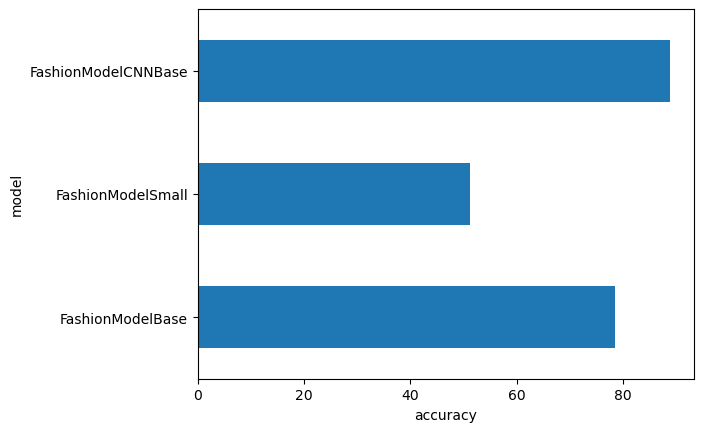

In [34]:
overall_results = pd.DataFrame(
    [model_0_results,model_1_results,model_2_results]
)

overall_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model")

In [35]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [36]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [37]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

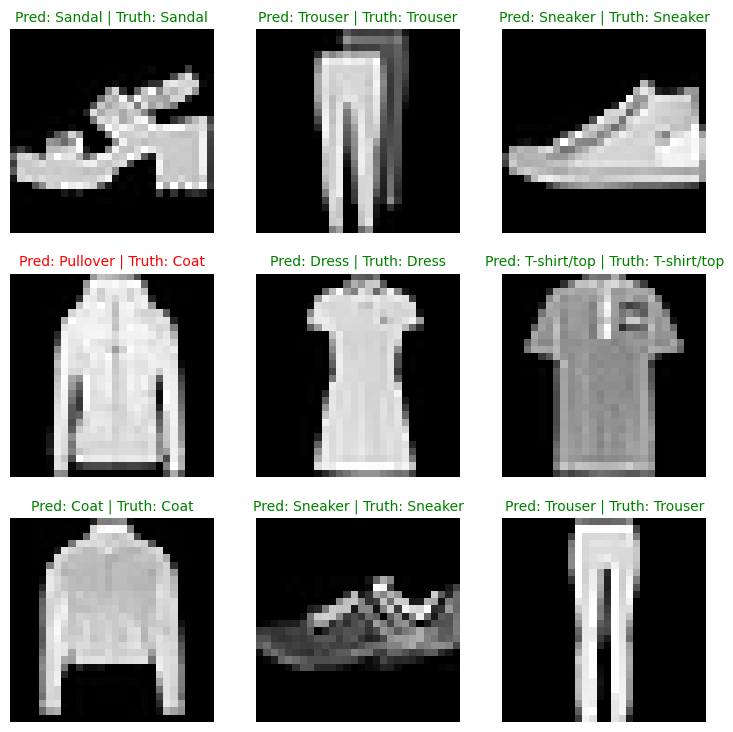

In [38]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [39]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [41]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

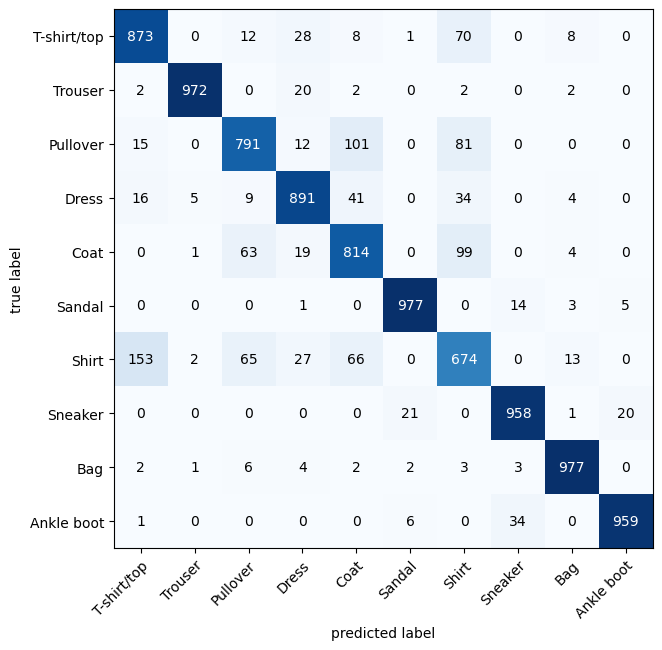

In [43]:
# !pip install mlxtend torchmetrics
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names),task="multiclass")
confmat_tensor = confmat(y_pred_tensor,test_data.targets)


fig,ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)





In [46]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "FashionCNN"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


torch.save(obj =  model_2.state_dict(),f=MODEL_SAVE_PATH)

In [49]:
torch.manual_seed(42)
load_model = FashionModelCNNBase(input_shape=1,hidden_units=10,output_shape=len(class_names))

load_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

load_model.to(device)


FashionModelCNNBase(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=360, out_features=10, bias=True)
  )
)

In [51]:
torch.manual_seed(42)

load_model_results = eval_model(
    load_model,
    test_dataloader,
    loss_fn,
    accuracy_fn,
    device
)
load_model_results

{'model_name': 'FashionModelCNNBase',
 'model_loss': 0.31103384494781494,
 'model_acc': 88.85782747603834}

In [52]:
model_2_results,load_model_results


({'model_name': 'FashionModelCNNBase',
  'model_loss': 0.31103384494781494,
  'model_acc': 88.85782747603834},
 {'model_name': 'FashionModelCNNBase',
  'model_loss': 0.31103384494781494,
  'model_acc': 88.85782747603834})